In [7]:
import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

- Question : Explore if an unsupervised algorithm can identify industries a group of journalists reports about
- Approach : We will tokenize and vectorize all documents, for unsupervised algorithms to be able to consume them
- Results : There are three major categories we could uncover from our analysis - journalists who write about China, ones who write about automobiles and finally the ones who write about finance and banking. The ones writing about finance are the most
- Conclusion : k-means on top of PCA is a very powerful tool to uncover otherwise hidden relationships

In [9]:
# Directory containing the author folders
base_dir = "/Users/amansharma/Documents/Acads/STA 380 Intro to ML/David Part 2/Questions/ReutersC50/C50train"

# List to store the data
data = []

# Iterate through each folder in the base directory
for author_folder in os.listdir(base_dir):
    author_path = os.path.join(base_dir, author_folder)
    
    # Check if the path is a directory (i.e., an author's folder)
    if os.path.isdir(author_path):
        # Iterate through each file in the author's folder
        for filename in os.listdir(author_path):
            file_path = os.path.join(author_path, filename)
            
            # Read the content of the file
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                
            # Append the author and content to the data list
            data.append([author_folder, content])

# Create a DataFrame with the collected data
df = pd.DataFrame(data, columns=['Author', 'Article'])


In [10]:
df.head()

,Author,Article
0,RobinSidel,Drugstore giant Revco D.S. Inc. said Monday it...
1,RobinSidel,"Mattel Inc., seeking to expand in the market f..."
2,RobinSidel,A financial agreement between Barney's Inc and...
3,RobinSidel,An independent shareholder advisory firm recom...
4,RobinSidel,Raising the stakes in the escalating battle fo...


#### We are trying to keep all core words - without punctuations and stop words. These core words should help assess the kind of news one reports 

In [12]:
import nltk
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Ensure that necessary NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Initialize the Porter Stemmer and stop words list
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Define a custom tokenizer function
def tokenizer(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Define a regex pattern to keep periods in abbreviations
    pattern = re.compile(r'[A-Za-z]\.[A-Za-z]')
    pattern_numeric = re.compile(r'^\d+$') 

    # Function to check if a token should be kept
    def is_valid_token(token):
        # If token matches the abbreviation pattern, drop it - these are most like proper nouns abbreviated
        if (pattern.match(token) or pattern_numeric.match(token)):
            return False
        # Remove single-letter words, punctuation, and stop words
        return (len(token) > 1 and
                token not in string.punctuation and
                token.lower() not in stop_words)
    
    # Remove unwanted tokens, then apply stemming
    tokens = [token for token in tokens if is_valid_token(token)]
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return stemmed_tokens

# Example usage with your DataFrame
df['Tokenized_Article'] = df['Article'].map(tokenizer)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amansharma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amansharma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df.head()

,Author,Article,Tokenized_Article
0,RobinSidel,Drugstore giant Revco D.S. Inc. said Monday it...,"[drugstor, giant, revco, inc., said, monday, a..."
1,RobinSidel,"Mattel Inc., seeking to expand in the market f...","[mattel, inc., seek, expand, market, boy, toy,..."
2,RobinSidel,A financial agreement between Barney's Inc and...,"[financi, agreement, barney, 's, inc, hong, ko..."
3,RobinSidel,An independent shareholder advisory firm recom...,"[independ, sharehold, advisori, firm, recommen..."
4,RobinSidel,Raising the stakes in the escalating battle fo...,"[rais, stake, escal, battl, conrail, inc., nor..."


### We will vectorize the documents now. First, we create a bag of words and then implement tf-idf

In [15]:
def tokens_to_text(tokens):
    return ' '.join(tokens)

# Apply the function to convert tokenized data to text format
df['Tokenized_Article'] = df['Tokenized_Article'].map(tokens_to_text)

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Step 2: Fit and transform the 'Article' column to get TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(df['Tokenized_Article'])

# Step 3: Convert the TF-IDF matrix to a DataFrame for easier manipulation
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Step 4: Add the 'Author' column back to the TF-IDF DataFrame
tfidf_df['Author'] = df['Author']

tfidf_df.head()

,00,000,00005,0003,002,003,004,005,006,01,...,zunxin,zuo,zurich,zwanzig,zwetchkenbaum,zx2,zygmunt,zyprexa,zyrtec,Author
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RobinSidel
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RobinSidel
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RobinSidel
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RobinSidel
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RobinSidel


In [16]:
tfidf_df.shape

(2500, 20306)

In [17]:
# Step 5: Aggregate the vectors by author (average or sum)
author_tfidf = tfidf_df.groupby('Author').mean().reset_index()

author_tfidf.head()


,Author,00,000,00005,0003,002,003,004,005,006,...,zuckschwerdt,zunxin,zuo,zurich,zwanzig,zwetchkenbaum,zx2,zygmunt,zyprexa,zyrtec
0,AaronPressman,0.000781,0.004334,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AlanCrosby,0.005444,0.013154,0.0,0.017526,0.004216,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AlexanderSmith,0.000000,0.007636,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BenjaminKangLim,0.000955,0.009209,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BernardHickey,0.000000,0.004256,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


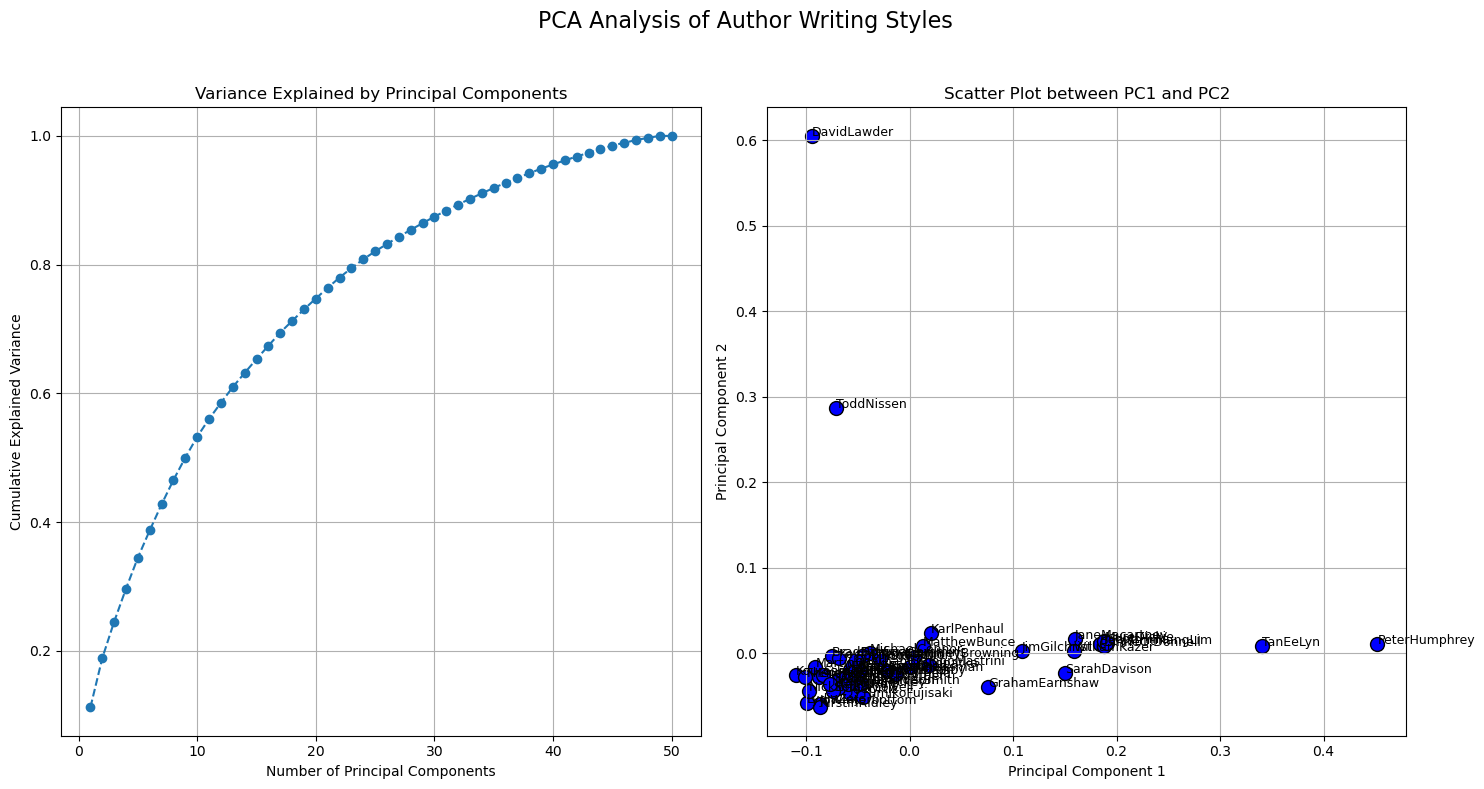

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns



# Step 1: Prepare the data for PCA
X = author_tfidf.drop('Author', axis=1)  # Drop the 'Author' column, we only want the TF-IDF vectors

# Step 2: Initialize and fit PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Step 3: Variance explained by each principal component
explained_variance = pca.explained_variance_ratio_

# Step 4: Set up a 2x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
fig.suptitle('PCA Analysis of Author Writing Styles', fontsize=16)

# Plot 1: Variance explained % against the number of PCs
axes[0].plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--')
axes[0].set_xlabel('Number of Principal Components')
axes[0].set_ylabel('Cumulative Explained Variance')
axes[0].set_title('Variance Explained by Principal Components')
axes[0].grid(True)

# Plot 2: A scatter plot between PC1 and PC2
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c='blue', edgecolor='k', s=100)
for i, author in enumerate(author_tfidf['Author']):
    axes[1].text(X_pca[i, 0], X_pca[i, 1], author, fontsize=9)
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
axes[1].set_title('Scatter Plot between PC1 and PC2')
axes[1].grid(True)


# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### The chart on the right is the image of our observations on the subspaces PC1 and PC2. There is a big blob of authors with very low weights. However, few authors have been separated well - Let's see what the model says about how journalists like David Lawder and Todd Nissen different from Peter Humphrey or TanEeLyn

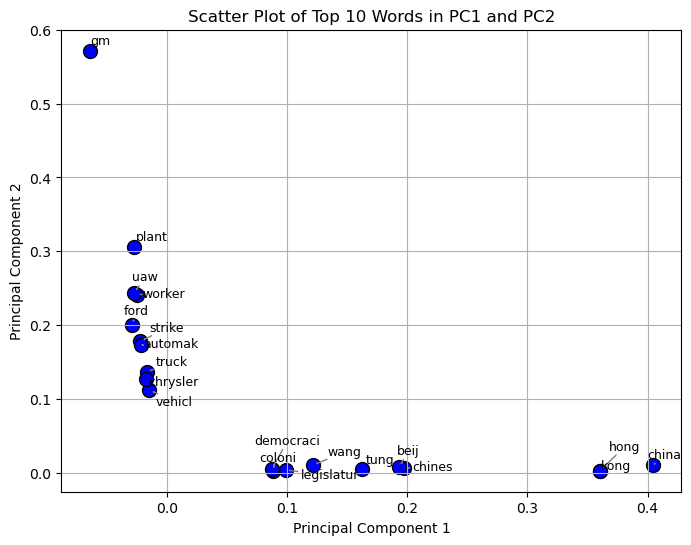

In [43]:

from adjustText import adjust_text
components_df = pd.DataFrame(pca.components_, index = [str("PC")+str(x) for x in range(1,51)], columns = X.columns)
# Transpose for easier manipulation
components_df_T = components_df.T

# Get the top and bottom 10 words for both PCs
top_bottom_words_pc1 = components_df_T['PC1'].nlargest(10).index.tolist()
top_bottom_words_pc2 = components_df_T['PC2'].nlargest(10).index.tolist()

# Combine lists to avoid duplicates and keep only the relevant words
relevant_words = set(top_bottom_words_pc1 + top_bottom_words_pc2)

# Filter the components_df_T to only include these relevant words
filtered_df = components_df_T.loc[list(relevant_words)]

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(filtered_df['PC1'], filtered_df['PC2'], color='blue', edgecolor='k', s=100)

# Annotate with word labels
texts = []
for i, word in enumerate(filtered_df.index):
    x, y = filtered_df['PC1'].iloc[i], filtered_df['PC2'].iloc[i]
    texts.append(plt.text(x, y, word, fontsize=9, ha='left', va='bottom', color='black'))

# Adjust text to avoid overlap
adjust_text(texts, only_move={'points': 'xy', 'text': 'xy'}, arrowprops=dict(arrowstyle='->', color='gray'))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of Top 10 Words in PC1 and PC2')
plt.grid(True)
plt.show()


#### The above chart is a column level decomposition of PC1 and PC2 (only the top 10 most heavily weighted words). Seems like PC1 is trying to capture journalists who write related to Asia - China / Taiwan; and PC2 captures those interested in car manufacturing. GM on the top left is short of general motors.

## Let's see doing clustering on top of PCA is able to uncover these different groups of journalists more clearly

Principal Components 2


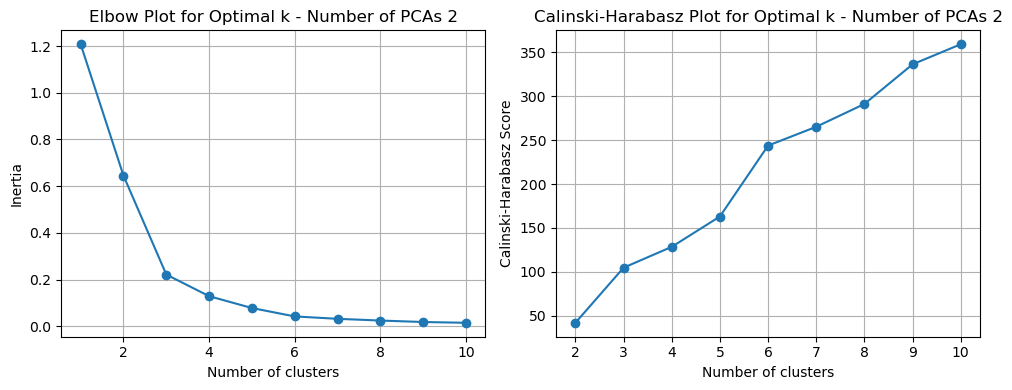

Principal Components 5


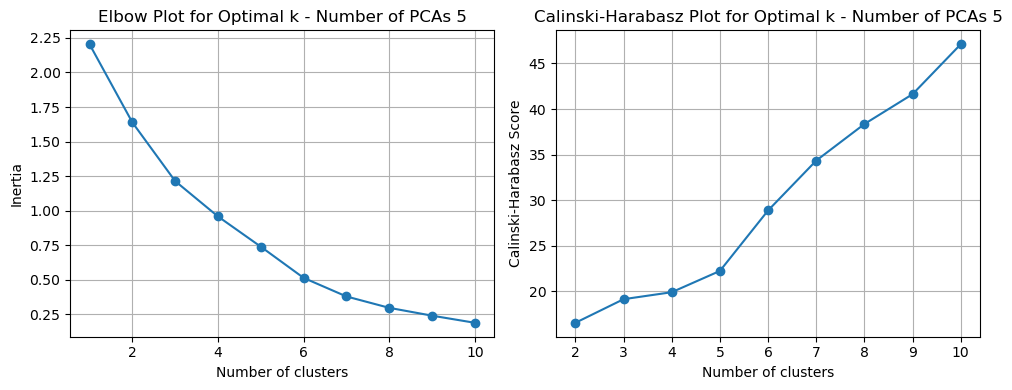

Principal Components 10


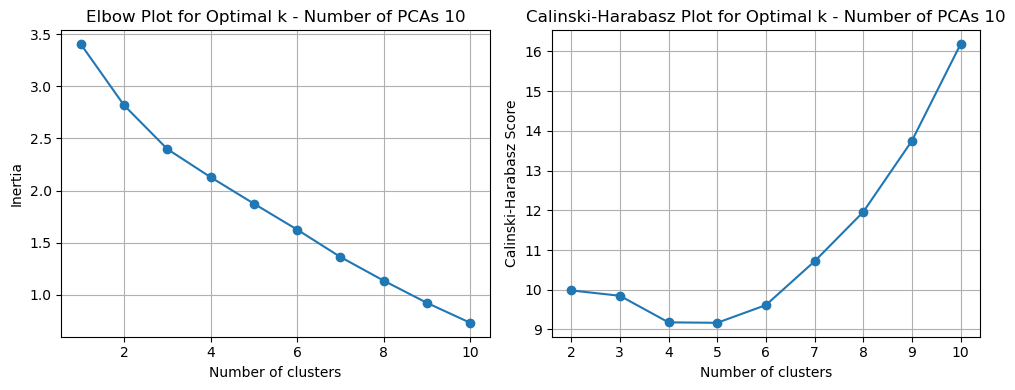

Principal Components 20


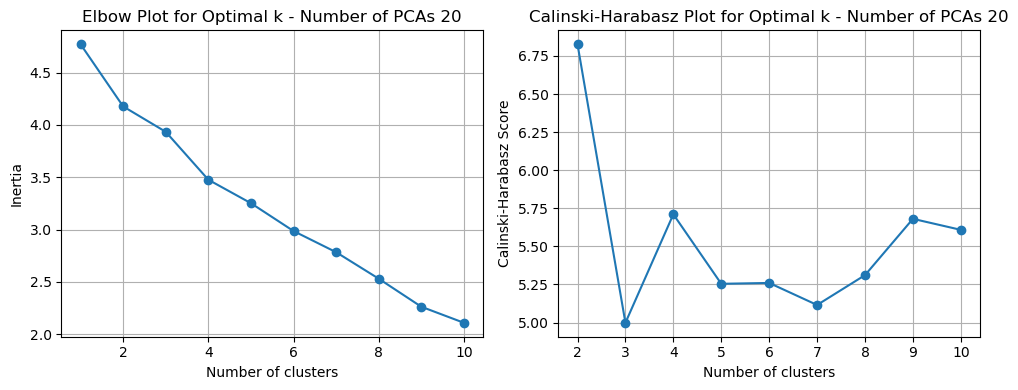

Principal Components 50


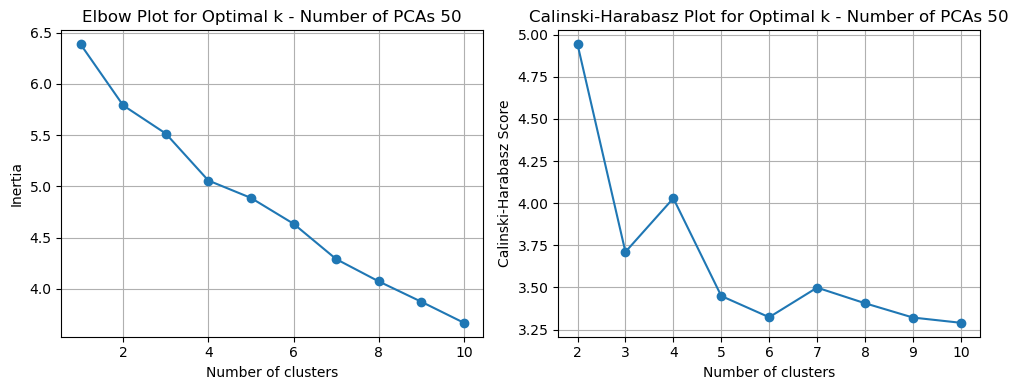

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Function to compute Calinski-Harabasz score
def compute_calinski_harabasz(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    return calinski_harabasz_score(X, labels)

# Function to plot Elbow Plot and CH Plot
def plot_elbow_and_ch(X, num_PCAs):
    inertia = []
    ch_scores = []
    K = range(1, 11)  # Testing cluster sizes from 1 to 10
    
    for k in K:
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
        
        if k > 1:  # Calinski-Harabasz index is not defined for k=1
            ch_score = compute_calinski_harabasz(X, k)
            ch_scores.append(ch_score)
        else:
            ch_scores.append(np.nan)  # Undefined for k=1

    # Plot Elbow Plot
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(K, inertia, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Plot for Optimal k - Number of PCAs {}'.format(num_PCAs))
    plt.grid(True)
    
    # Plot Calinski-Harabasz Index Plot
    plt.subplot(1, 2, 2)
    plt.plot(K, ch_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Calinski-Harabasz Score')
    plt.title('Calinski-Harabasz Plot for Optimal k - Number of PCAs {}'.format(num_PCAs))
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Working with 10 PCAs, they capture 50% of variance


for i in [2,5,10,20,50]:
    print ('Principal Components {}'.format(i))
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X)
    plot_elbow_and_ch(X_pca, i)
    


#### Observation 1 - Increasing the number of PCAs adversely impacts both Inertia and CH Score. It seems adding more PCAs adds noise. We will continue with PCA = 2
#### Observation 2 - Focusing on the CH plots for number of PCA 2 through 10, it seems 3 clusters is an optimal number

### Here is a PCA on all features (not PCAs)

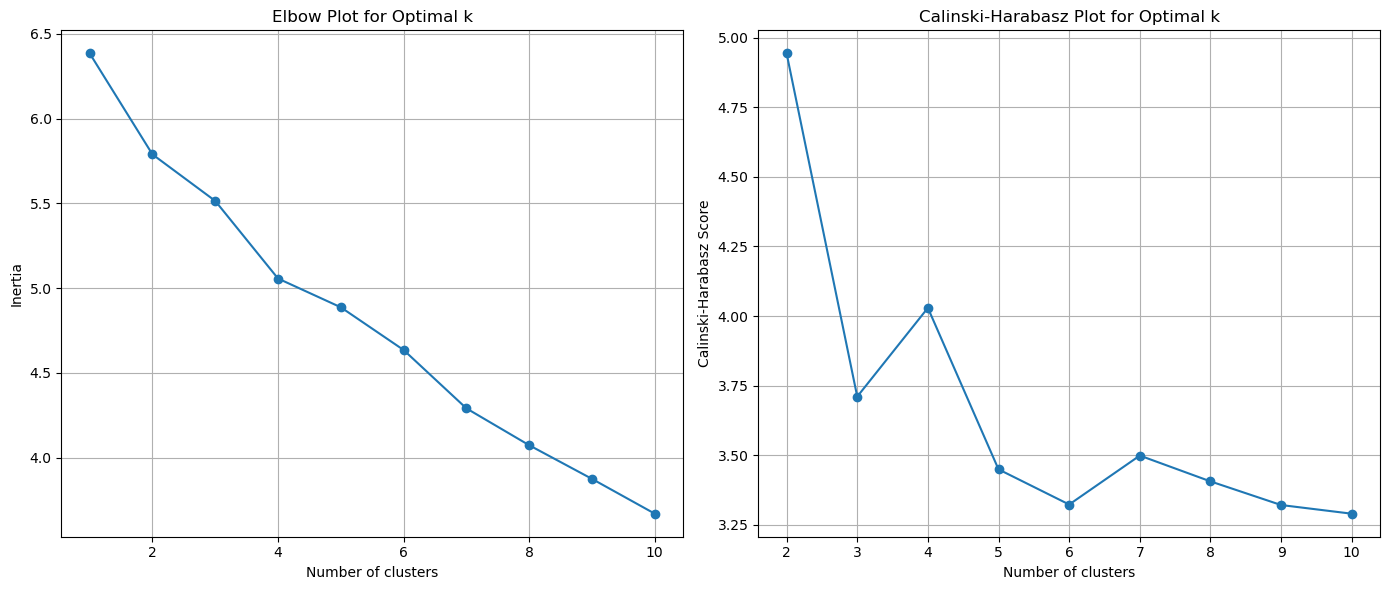

In [45]:
plot_elbow_and_ch(X)


### Comparing both Inertia and CH Score, it is evident that Clustering does a better job when combined with PCA

### This is what we have so far 3 clusters, 2 PCAs. Let's see if changing the distance measure does us any good!

In [69]:
!pip install scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 4.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.3.0-cp311-cp311-macosx_11_0_arm64.whl size=389061 sha256=fae3803af1d57ff02695daabb864810992c8a6130ff2a70d8be947d9178dc839
  Stored in directory: /Users/amansharma/Library/Caches/pip/wheels/9c/cb/bd/4f19f79eee4fe83d1303d9be845bf9b07507dcac5439fa30ba
Successfully built scikit-learn-extra


Principal Components 2


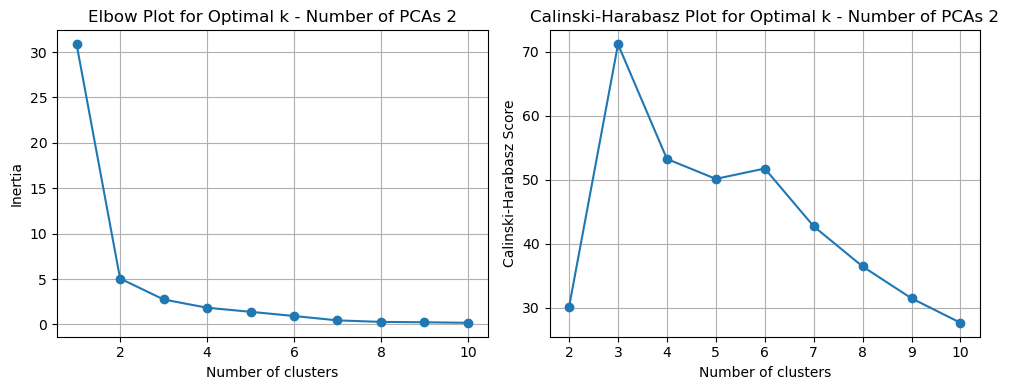

In [73]:

from sklearn_extra.cluster import KMedoids
def compute_calinski_harabasz_cosine_dis(X, n_clusters):
    kmeans = KMedoids(n_clusters=n_clusters, metric='cosine', init='k-medoids++', random_state=42)

    kmeans.fit(X)
    labels = kmeans.labels_
    return calinski_harabasz_score(X, labels)

def plot_elbow_and_ch_cosine_dis(X, num_PCAs):
    inertia = []
    ch_scores = []
    K = range(1, 11)  # Testing cluster sizes from 1 to 10
    
    for k in K:
        # kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
        kmeans = KMedoids(n_clusters=k, metric='cosine', init='k-medoids++', random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
        
        if k > 1:  # Calinski-Harabasz index is not defined for k=1
            ch_score = compute_calinski_harabasz_cosine_dis(X, k)
            ch_scores.append(ch_score)
        else:
            ch_scores.append(np.nan)  # Undefined for k=1

    # Plot Elbow Plot
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(K, inertia, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Plot for Optimal k - Number of PCAs {}'.format(num_PCAs))
    plt.grid(True)
    
    # Plot Calinski-Harabasz Index Plot
    plt.subplot(1, 2, 2)
    plt.plot(K, ch_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Calinski-Harabasz Score')
    plt.title('Calinski-Harabasz Plot for Optimal k - Number of PCAs {}'.format(num_PCAs))
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


print ('Principal Components {}'.format(2))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plot_elbow_and_ch_cosine_dis(X_pca, 2)
    
    


### Cosine distance gives a much stronger evidence for 3 clusters
### So our final selection is 3 clusters, 2 PCA and cosine distance measure

In [79]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

kmeans = KMedoids(n_clusters=3, metric='cosine', init='k-medoids++', random_state=42)
kmeans.fit(X_pca)
labels = kmeans.labels_


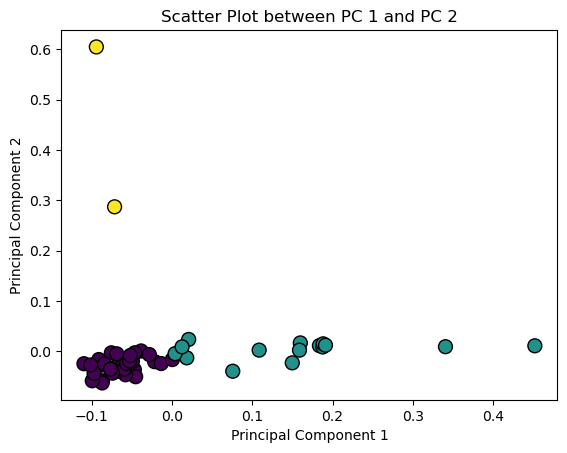

In [81]:

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels,  edgecolor='k', s=100)
plt.xlabel(f'Principal Component 1')
plt.ylabel(f'Principal Component 2')
plt.title(f'Scatter Plot between PC 1 and PC 2')
plt.show()

### Let's take back kmeans labels to our original dataset and see what we have

In [84]:
author_tfidf.loc[:,'labels'] = labels
author_tfidf.drop(['Author'], axis=1).groupby(['labels']).mean().T.idxmax()

labels
0     said
1    china
2       gm
dtype: object

#### Looks like the first label has a generic word "said" with the most mean weight, the second one has "china" and third one has "gm" - general motors. Let's look at more words from each label

In [90]:
dic = {}
for col in list(set(labels)):
    temp = author_tfidf.drop(['Author'], axis=1).groupby(['labels']).mean()
    dic[col] = temp[temp.index == col].T.sort_values(by = col, ascending = False).index[:5]
dic

{0: Index(['said', 'compani', 'bank', 'million', 'analyst'], dtype='object'),
 1: Index(['china', 'said', 'hong', 'kong', 'chines'], dtype='object'),
 2: Index(['gm', 'plant', 'ford', 'worker', 'uaw'], dtype='object')}

#### Looking at the most highly weighted words across the three clusters it is clear that <br> 
##### - the first cluster is putting together journalists who write about banking and finance <br> 
##### - the second one puts together the ones who write about China / Asia , and <br> 
##### - finally, the third puts together journalist who write about auto mobiles industry